In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import math
import random

import numpy as np
import pytest
import torch
import scipy.optimize
import socialforce


OPTIMIZER_OPT = {'eps': 1e-4, 'gtol': 1e-4, 'maxcor': 30, 'maxls': 10, 'disp': True}

[Sven Kreiss](https://www.svenkreiss.com), April 17 2020

# Fit PedPed Potential

In [2]:
def visualize(file_prefix, V, initial_parameters, final_parameters, fit_result=None, V_gen=None):
    b = np.linspace(0, 3, 200)
    y_ref = 2.1 * np.exp(-1.0 * b / 0.3)
    if V_gen is not None:
        y_ref = V_gen.v0 * np.exp(-1.0 * b / V_gen.sigma)

    V.set_parameters(torch.tensor(initial_parameters))
    y_initial = V.value_b(torch.from_numpy(b)).detach().numpy()
    y_initial -= y_initial[-1]

    if not isinstance(final_parameters, torch.Tensor):
        final_parameters = torch.tensor(final_parameters)
    V.set_parameters(final_parameters)
    y_mlp = V.value_b(torch.from_numpy(b)).detach().numpy()
    y_mlp -= y_mlp[-1]

    with socialforce.show.canvas(file_prefix + 'v_gradv.png', ncols=2) as (ax1, ax2):
        ax1.set_xlabel('$b$ [m]')
        ax1.set_ylabel('$V$')
        ax1.plot(b, y_ref, label=r'true $V_0 e^{-b/\sigma}$', color='gray')
        ax1.axvline(0.3, color='gray', linestyle='dotted', label=r'true $\sigma$')
        ax1.plot(b, y_initial, label=r'initial MLP($b$)',
                linestyle='dashed', color='C0')
        ax1.plot(b, y_mlp, label=r'MLP($b$)', color='C0')
        ax1.legend()

        ax2.set_xlabel(r'$b$ [m]')
        ax2.set_ylabel(r'$\nabla V$')
        delta_b = b[1:] - b[:-1]
        average_b = 0.5 * (b[:-1] + b[1:])
        ax2.plot(average_b, (y_ref[1:] - y_ref[:-1]) / delta_b,
                label=r'true $V_0 e^{-b/\sigma}$', color='gray')
        ax2.axvline(0.3, color='gray', linestyle='dotted', label=r'true $\sigma$')
        ax2.plot(average_b, (y_initial[1:] - y_initial[:-1]) / delta_b,
                label=r'initial MLP($b$)',
                linestyle='dashed', color='C0')
        ax2.plot(average_b, (y_mlp[1:] - y_mlp[:-1]) / delta_b,
                label=r'MLP($b$)', color='C0')
        ax2.set_ylim(-4.9, 0.5)
        ax2.legend()

## Generate Truth for Opposing Scenario

Left: $\Delta t = 0.4s$  
Right: $\Delta t = 0.05s$

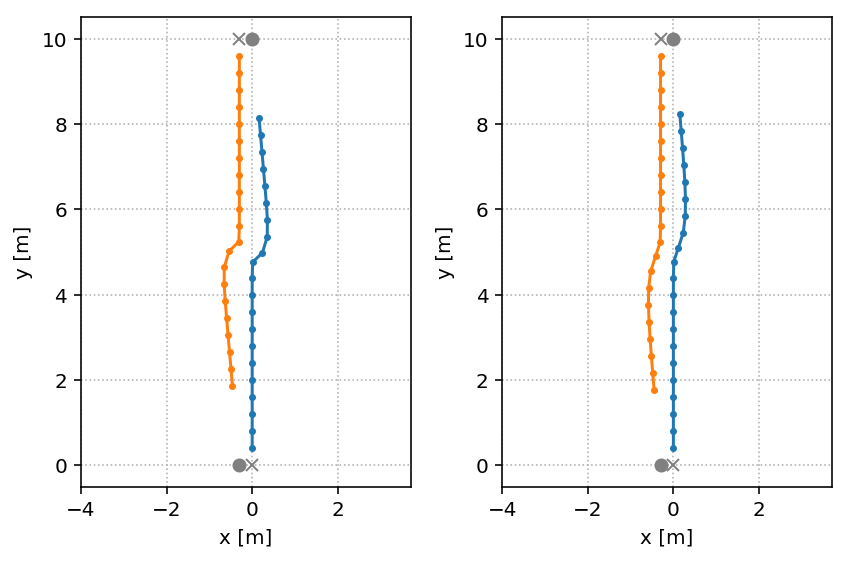

In [3]:
initial_state = [
    [0.0, 0.0, 0.0, 1.0, 0.0, 10.0],
    [-0.3, 10.0, 0.0, -1.0, -0.3, 0.0],
]

truth_nooversampling = socialforce.Simulator(initial_state, oversampling=1).run(21)
truth = socialforce.Simulator(initial_state).run(21)

with socialforce.show.track_canvas(ncols=2) as (ax1, ax2):
    socialforce.show.states(ax1, truth_nooversampling)
    socialforce.show.states(ax2, truth)

## Fit a Potential with Manual Gradient Descent Implementation

In [4]:
v0 = torch.tensor(1.2, dtype=torch.double, requires_grad=True)
sigma_v = torch.tensor(0.1, dtype=torch.double, requires_grad=True)
V = socialforce.PedPedPotential(v0, sigma_v)
initial_states = socialforce.Simulator(initial_state, ped_ped=V).run(21)

for i_update in range(100):
    generated_states = socialforce.Simulator(initial_state, ped_ped=V).run(21, detach=False)
    # generated_states = socialforce.Simulator(initial_state, ped_ped=V, oversampling=1, delta_t=0.04).run(210, detach=False)
    loss_l2 = (generated_states[1:, :, :2]-truth[1:, :, :2]).norm(dim=-1).sum()
    # loss_l2 = (generated_states[10::10, :, :2]-truth[1:, :, :2]).norm(dim=-1).sum()
    loss_constantv = (generated_states[2:, :, 2:4] - generated_states[1:-1, :, 2:4]).norm(dim=-1).sum()
    loss = loss_l2 + 0.0001 * loss_constantv
    print('losses', loss, loss_l2, loss_constantv)

    v0_grad, sigma_grad = torch.autograd.grad(loss, [v0, sigma_v])

    lr = 10.0 if i_update < 50 else 1.0
    with torch.no_grad():
        v0 -= lr * v0_grad
        sigma_v -= lr * sigma_grad

    print('v0', v0, v0_grad)
    print('sigma', sigma_v, sigma_grad)

assert v0.item() == pytest.approx(2.1, abs=0.01)
assert sigma_v.item() == pytest.approx(0.3, abs=0.01)

losses tensor(4.3761, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(4.3761, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.2823, dtype=torch.float64, grad_fn=<SumBackward0>)
v0 tensor(1.2012, dtype=torch.float64, requires_grad=True) tensor(-0.0001, dtype=torch.float64)
sigma tensor(0.1658, dtype=torch.float64, requires_grad=True) tensor(-0.0066, dtype=torch.float64)
losses tensor(3.5160, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(3.5159, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(0.6638, dtype=torch.float64, grad_fn=<SumBackward0>)
v0 tensor(1.2080, dtype=torch.float64, requires_grad=True) tensor(-0.0007, dtype=torch.float64)
sigma tensor(0.2822, dtype=torch.float64, requires_grad=True) tensor(-0.0116, dtype=torch.float64)
losses tensor(2.3318, dtype=torch.float64, grad_fn=<AddBackward0>) tensor(2.3317, dtype=torch.float64, grad_fn=<SumBackward0>) tensor(1.1082, dtype=torch.float64, grad_fn=<SumBackward0>)
v0 tensor(1.2258, dtype=torch.float64, requires_g

AssertionError: 

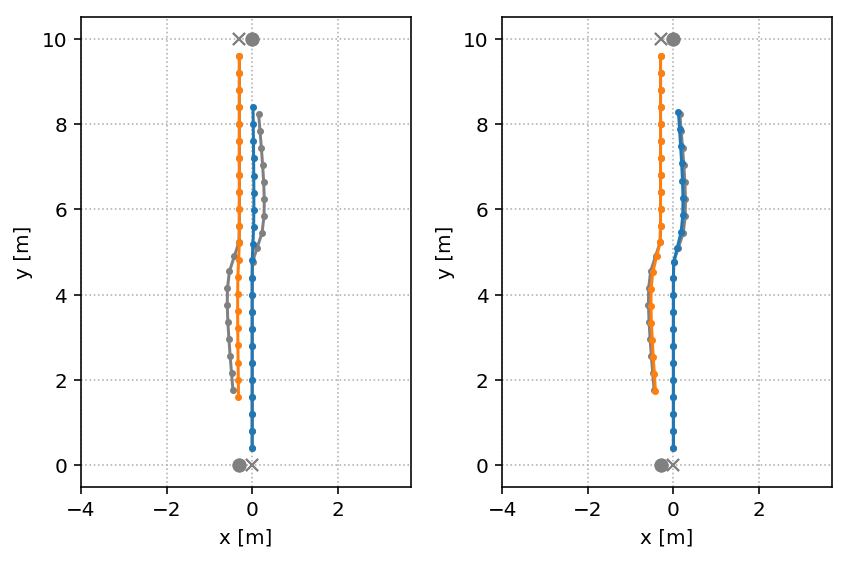

In [5]:
final_states = socialforce.Simulator(initial_state, ped_ped=V).run(21)
with socialforce.show.track_canvas(ncols=2) as (ax1, ax2):
    socialforce.show.states(ax1, truth, color='grey')
    socialforce.show.states(ax1, initial_states)
    socialforce.show.states(ax2, truth, color='grey')
    socialforce.show.states(ax2, final_states)

## Fit a Potential with Numerical Gradient Approximation with SciPy

In [17]:
def f(x):
    V = socialforce.PedPedPotential(float(x[0]), float(x[1]))

    generated_states = socialforce.Simulator(initial_state, ped_ped=V).run(21)
    loss = (generated_states[1:, :, :2] - truth[1:, :, :2]).norm(dim=-1).sum()

    return loss

parameters = np.array([1.2, 0.1])
res = scipy.optimize.minimize(f, parameters, method='L-BFGS-B', options=OPTIMIZER_OPT)
print(res)

assert res.x == pytest.approx(np.array([2.1, 0.3]), abs=0.01)

fun: tensor(0.0002, dtype=torch.float64)
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.70067465, 11.83149875])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 165
      nit: 11
   status: 2
  success: False
        x: array([2.09967295, 0.30005335])


# Fit an MLP Potential with Numerical Gradient with SciPy

In [10]:
torch.manual_seed(42)
np.random.seed(42)

V = socialforce.PedPedPotentialMLP().double()
parameters = V.get_parameters().clone().detach().numpy()
initial_parameters = parameters.copy()

# training
def f(x):
    V.set_parameters(torch.from_numpy(x))
    generated_states = socialforce.Simulator(initial_state, ped_ped=V).run(21)

    loss = (generated_states[1:, :, :2] - truth[1:, :, :2]).norm(dim=-1).sum()

    return loss

res = scipy.optimize.minimize(f, parameters, method='L-BFGS-B', options=OPTIMIZER_OPT)
print(res)

fun: tensor(0.0249, dtype=torch.float64)
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.13180881e-01,  1.29603329e+00,  7.35197926e-02, -1.46080760e-02,
        1.02845925e-02,  1.90183960e-01,  3.28137594e-05, -2.10131808e-01,
        6.88225820e-04,  2.67763949e-02, -1.11166119e-01,  1.47803874e-03,
       -1.20844379e-01, -4.86889979e-02, -1.25005174e-01])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 1008
      nit: 23
   status: 2
  success: False
        x: array([ 4.65933723e-01,  1.64685606e-03,  5.47505531e-01,  2.64704716e+00,
        6.54232771e-01,  1.09438963e-01,  1.36202011e-02,  6.00547103e-02,
       -1.58514700e-01, -2.47175056e-02,  1.01542953e+00, -4.97697818e-01,
       -1.33191574e+00, -1.35587622e+00,  1.22539881e-01])


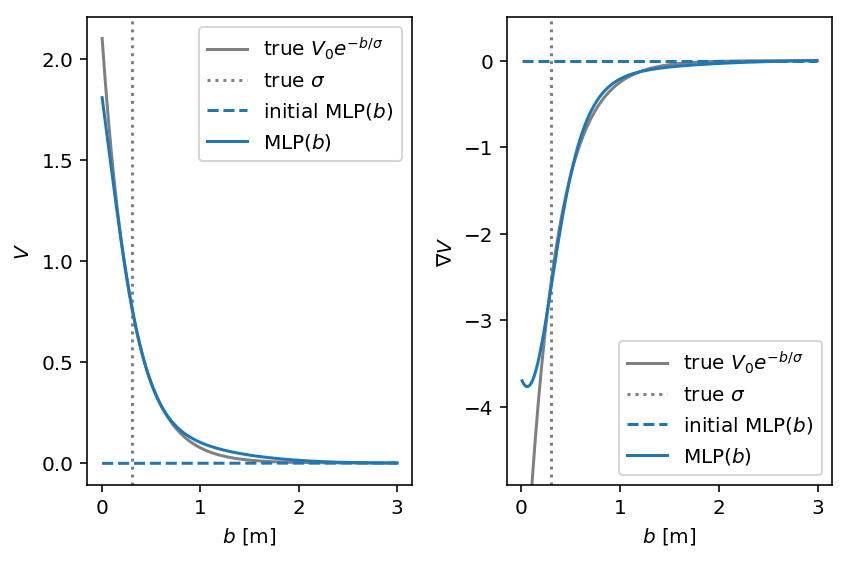

In [16]:
visualize('images/mlp_scipy_', V, initial_parameters, res.x)

## Fitting to 1, 5 and 20 Circle Scenarios each with Two Pedestrians

The preferred speed needs to be varied. Otherwise the symmetry of the problem creates unrealistic scenarios where the two pedestrians get stuck.

In [5]:
def generate_gt(n):
    torch.manual_seed(42)
    np.random.seed(42)

    # ped0 always left to right
    ped0 = np.array([-5.0, 0.0, 1.0, 0.0, 5.0, 0.0])

    generator_initial_states = []
    for theta in np.random.rand(n) * 2.0 * math.pi:
        # ped1 at a random angle with +/-20% speed variation
        c, s = np.cos(theta), np.sin(theta)
        r = np.array([[c, -s], [s, c]])
        ped1 = np.concatenate((
            np.matmul(r, ped0[0:2]),
            np.matmul(r, ped0[2:4]) * (0.8 + np.random.rand(1) * 0.4),
            np.matmul(r, ped0[4:6]),
        ))
        generator_initial_states.append(
            np.stack((ped0, ped1))
        )

    generator_ped_ped = socialforce.PedPedPotential(2.1)
    return generator_ped_ped, [
        socialforce.Simulator(initial_state, ped_ped=generator_ped_ped).run(21)
        for initial_state in generator_initial_states
    ]

generator_pedped_1, scenarios_1 = generate_gt(1)
generator_pedped_5, scenarios_5 = generate_gt(5)
generator_pedped_20, scenarios_20 = generate_gt(20)

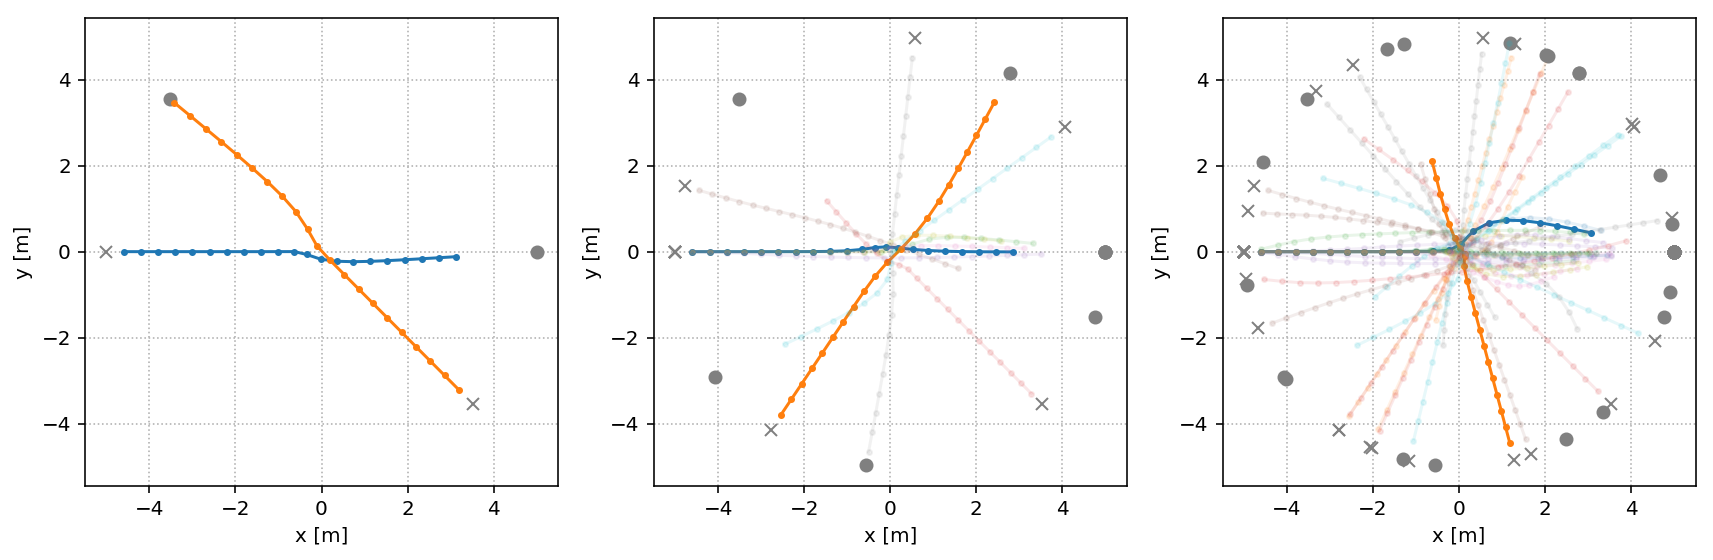

In [6]:
with socialforce.show.track_canvas(ncols=3, figsize=(12, 4)) as (ax1, ax2, ax3):
    socialforce.show.states(ax1, scenarios_1[0])

    socialforce.show.states(ax2, scenarios_5[-1])
    for scene in scenarios_5[:-1]:
        socialforce.show.states(ax2, scene, alpha=0.1)

    socialforce.show.states(ax3, scenarios_20[-1])
    for scene in scenarios_20[:-1]:
        socialforce.show.states(ax3, scene, alpha=0.1)

In [13]:
true_experience = socialforce.Optimizer.scenes_to_experience(scenarios_1)
V = socialforce.PedPedPotentialMLP().double()
initial_parameters = V.get_parameters().clone().detach().numpy()

def simulator_factory(initial_state):
    s = socialforce.Simulator(initial_state, ped_ped=V)
    # s.desired_speeds = generator.desired_speeds
    # s.max_speeds = generator.max_speeds
    return s

opt = socialforce.Optimizer(simulator_factory, V.parameters(), true_experience, lr=100.0)
for i in range(100 // 1):
    loss = opt.epoch()
    print('epoch {}: {}'.format(i, loss))

epoch 0: 0.011176219794354784
epoch 1: 0.010905500395375392
epoch 2: 0.01041007054293353
epoch 3: 0.009699481440937855
epoch 4: 0.008577941317957282
epoch 5: 0.007436217736195011
epoch 6: 0.00635104702409268
epoch 7: 0.005551476504066
epoch 8: 0.00477255878609416
epoch 9: 0.003913129034381452
epoch 10: 0.0036713561002451912
epoch 11: 0.0032719044537018686
epoch 12: 0.0031568037831759734
epoch 13: 0.0024582916004395423
epoch 14: 0.002590676301365948
epoch 15: 0.002433084764717224
epoch 16: 0.0022965260399868672
epoch 17: 0.002376769064326289
epoch 18: 0.0019593244369354775
epoch 19: 0.002042551968393518
epoch 20: 0.0018385249410270688
epoch 21: 0.001927616215211488
epoch 22: 0.001844375893612359
epoch 23: 0.001783249128981922
epoch 24: 0.0015700090698472936
epoch 25: 0.0017087640296155938
epoch 26: 0.0015838536531320672
epoch 27: 0.001507782424189555
epoch 28: 0.0015070963606659126
epoch 29: 0.001556413052764538
epoch 30: 0.0014548154314933007
epoch 31: 0.0014681681900485135
epoch 32: 0

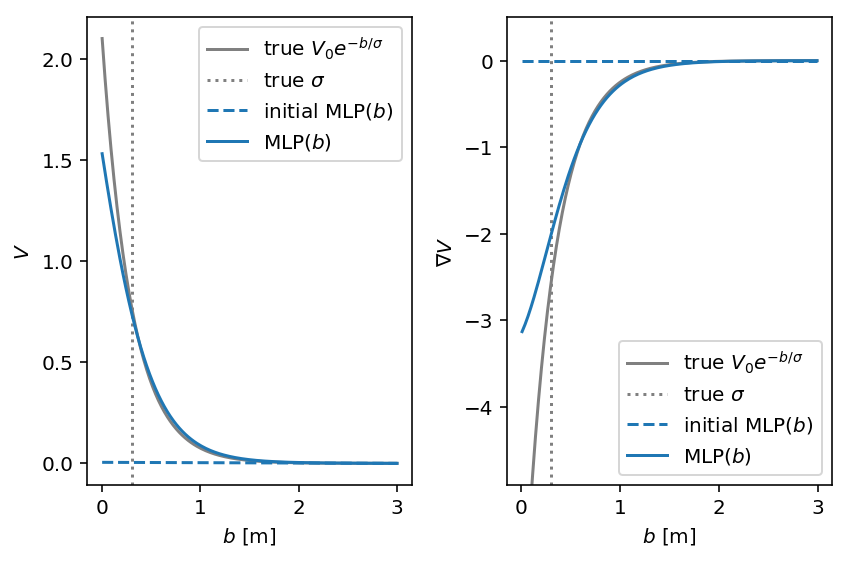

In [14]:
# make plots of result
visualize('images/mlp_circle_n{}_'.format(1), V, initial_parameters, V.get_parameters().clone(), V_gen=generator_pedped_1)